<a href="https://colab.research.google.com/github/aadi-kanwar/Gen-AI/blob/main/Exp_5_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [3]:
batch_size = 16
epoch_count = 50
noise_dim = 100
n_class = 10
tags = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
img_size = 32
(x_train,y_train),(_, _) = cifar10.load_data()

x_train = (x_train - 127.5) / 127.5

dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


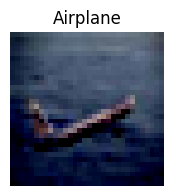

In [16]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(x_train))
img = x_train[idx]
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()
# img = image.array_to_img(x_train[idx], scale = True)
# plt.show()

In [17]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

def dsicriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real)
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds)

d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [19]:
def build_generator():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)
    n_nodes = 8 * 8
    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((8,8,1))(li)

    #image generator input
    in_lat = tf.keras.layers.Input(shape=(noise_dim,))

    n_nodes = 128 * 8 * 8
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((8,8,128))(gen)

    merge = tf.keras.layers.Concatenate()([gen, li])

    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    out_layer = tf.keras.layers.Conv2D(3, (8,8), activation='tanh', padding='same')(gen)

    model = tf.keras.models.Model([in_lat, in_label], out_layer)
    return model

g_model = build_generator()
g_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8192)           │        827,392 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │            500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 8192)           │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 64)          │          3,264 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 8, 8, 128)      │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8, 8, 1)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 129)      │              0 │ reshape_1[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        264,320 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 128)    │        262,272 │ leaky_re_lu_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 3)      │         24,579 │ leaky_re_lu_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def build_discriminator():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)

    n_nodes = img_size * img_size
    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((img_size,img_size,1))(li)

    #image Input
    in_image = tf.keras.layers.Input(shape=(img_size,img_size,3))

    merge = tf.keras.layers.Concatenate()([in_image, li])

    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

    fe = tf.keras.layers.Flatten()(fe)

    fe = tf.keras.layers.Dropout(0.4)(fe)
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)

    model = Model([in_image, in_label], out_layer)
    return model

d_model = build_discriminator()
d_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │            500 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1024)        │         52,224 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 32, 32, 1)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 4)      │              0 │ input_layer_3[0][0],   │
│ (Concatenate)             │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │          4,736 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8192)           │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          8,193 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
@tf.function
def train_step(dataset):
    real_images, real_labels = dataset
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model([random_latent_vectors, real_labels])

    #Train with Discriminator
    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])
        d_loss = dsicriminator_loss(pred_real, pred_fake)

    grads = tape.gradient(d_loss, d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

    with tf.GradientTape() as tape:
        fake_images = g_model([random_latent_vectors, real_labels])
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)

In [24]:
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(10, num_samples, figsize=(10,20))
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in np.arange(10):
        random_noise = tf.random.normal(shape=(num_samples, noise_dim))
        labels = tf.ones(num_samples)*1
        gen_images = g_model([random_noise, labels])
        for j in range(gen_images[0]):
            img = image.array_to_img(gen_images[j], scale = True)
            axes[l,j].imshow(img)
            axes[l,j].yaxis.set_ticks([])
            axes[l,j].xaxis.set_ticks([])

            if j==0:
                axes[l,j].set_ylabel(tags[l])
        plt.show()

In [25]:
def train(dataset, epochs = epoch_count):
    for epoch in range(epochs):
        print('Epoch: ',epochs)
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()

        itern = 0